## For working with other image sequences without modifying the original working notebook

In [2]:
import numpy as np
from skimage import io, filters
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatch
from corrLib import readdata
from IPython.display import clear_output
import pandas as pd
from myImageLib import to8bit, show_progress
import time

In [237]:
folder = '/home/zhengyang/data/DE/08042021/2021-08-04_16h37m16s'
l = readdata(os.path.join(folder, 'images'), 'tif')
num_images = len(l)
print('Total {:d} frames'.format(num_images))

Total 3611 frames


In [188]:
l.loc[l.Name=='00067808']

,Name,Dir
1600,00067808,/home/zhengyang/data/DE/07202021/1st-drop-trac...


<font color='red'> Run the cell below

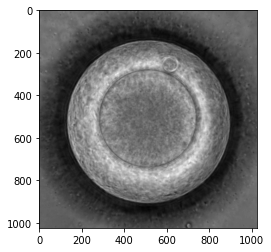

In [238]:
# show image 1 and manually crop
img = io.imread(l.Dir[0])
plt.imshow(img, cmap='gray')

<font color='red'> Set `crop_anchor` and `crop_size` so that inner drop is the majority of the cropped image

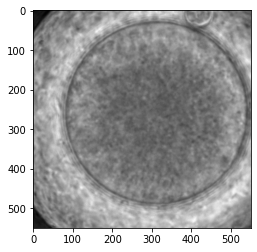

In [239]:
# test the first cropped image
crop_anchor = np.array([250, 200]) # upper left corner coords, int
crop_size = (550, 550) # height and width, int
crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
       crop_anchor[1], crop_anchor[1]+crop_size[1])
# need to check if the crop exceeds the borders of images
cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped, cmap='gray')

<font color='red'> Set `Hough_maxRadius` and `Hough_minRadius`, in cases where no circle can be detected or the circle detected is way off, modify `Hough_dp`  

1
CPU times: user 1.57 s, sys: 24.2 ms, total: 1.59 s
Wall time: 206 ms


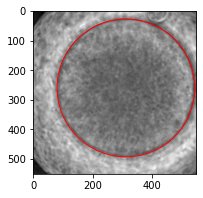

In [240]:
%%time
# test HoughCircles params

Hough_dp = 1.2
Hough_minDist = max(crop_size)
Hough_param2 = 5
Hough_maxRadius = 250
Hough_minRadius = 200
circles = cv2.HoughCircles(to8bit(cropped), cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cropped, cmap='gray')
circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), circles[0, 0, 2],
                             fill=False, ec='red', lw=1)
ax.add_patch(circle_object)
print(len(circles))

In [241]:
# Initial params
# crop_anchor = np.array([190, 140]) # upper left corner coords, int
# crop_size = (90, 90) # height and width, int
save_crop_step = 10 # save cropped image every save_crop_step steps, int
start_frame = 0
end_frame = None

# HoughCircles params
# Hough_dp = 1.2
# Hough_minDist = max(crop_size)
# Hough_param2 = 1
# Hough_maxRadius = 40
# Hough_minRadius = 30

# initialize result containers
x_list = [] # x of circle
y_list = [] # y of circle
filename_list = [] # filename of raw image
nc_list = [] # number of circles detected in each frame

# initialize output folder
main_output_folder = os.path.join(folder, 'crop_HoughCircles')
cropped_folder = os.path.join(main_output_folder, 'cropped')
if os.path.exists(main_output_folder) == False:
    os.makedirs(main_output_folder)
if os.path.exists(cropped_folder) == False:
    os.makedirs(cropped_folder)

print("start working on {}".format(folder))

for num, i in l.iterrows():
    if num < start_frame:
        continue
    # read image and convert to 8-bit (HoughCircles requires 8-bit images)
    img = to8bit(io.imread(i.Dir))

    # set crop using crop_anchor and crop_size
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
    # need to check if the crop exceeds the borders of images
    cropped = img[max(crop[0], 0):min(crop[1], img.shape[0]), max(crop[2], 0):min(crop[3], img.shape[1])]
    # use HoughCircles to detect circles in the cropped image
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None: # check if any circle is detected
        x, y = circles[0, 0, 0]+crop_anchor[1], circles[0, 0, 1]+crop_anchor[0]
        # NOTE: the circle coords given by HoughCircles is in (x, y), i.e. horizontal then vertical 
        #       to be consistent with the row-column coords, we need to put circles[0,0,1] as the "row" #
        #       and circles[0,0,0] as the "column" #
        
        # update crop_anchor with the position of circle detected
        crop_anchor = np.array([y-crop_size[1]/2, x-crop_size[0]/2]).astype('int')
        if num % save_crop_step == 0: # save cropped image and detecting result for validating purpose
            fig = plt.figure(figsize=(3, 3))
            ax = fig.add_axes([0,0,1,1])
            ax.imshow(cropped, cmap='gray')
            circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), circles[0, 0, 2],
                                         fill=False, ec='red', lw=1)
            ax.add_patch(circle_object)
            fig.savefig(os.path.join(cropped_folder, '{}.jpg'.format(i.Name)))
            plt.close() # prevent figure from showing up inline
            show_progress(num/num_images)
            clear_output(wait=True)
    else:
        # if no circle is detected, set x, y to NaN
        x, y = np.nan, np.nan
    
    # record information from each step in lists
    filename_list.append(i.Name)
    x_list.append(x)
    y_list.append(y) 
        
    # check end_frame
    if end_frame is not None:
        if num >= end_frame-1:
            break

data = pd.DataFrame({'x':x_list, 'y':y_list, 'filename':filename_list})
data.to_csv(os.path.join(main_output_folder, 'traj.csv'), index=False)

 [###########################################################-] 100.0%


In [216]:
num

275

In [116]:
l.loc[l.Name=='00027189']

,Name,Dir
600,00027189,/home/zhengyang/data/DE/07202021/1st-drop-trac...


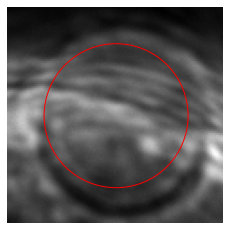

In [198]:
# check tracking quality
start = 1590
interval = 10
end = 1620

# load data from file
data = pd.read_csv(os.path.join(main_output_folder, 'traj.csv'))

for num, i in data.iterrows():
    if num < start:
        continue
    if num % interval == 0:
        img = io.imread(os.path.join(folder, 'images',  '{:08d}.tif'.format(int(i.filename))))
        crop_anchor = [int(i.y-crop_size[0]/2), int(i.x-crop_size[1]/2)]
        crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
        cropped = img[max(crop[0], 0):min(crop[1], img.shape[0]), max(crop[2], 0):min(crop[3], img.shape[1])]
        
        fig = plt.figure(figsize=(3, 3))
        ax = fig.add_axes([0,0,1,1])
        ax.imshow(cropped, cmap='gray')
        circle_object = mpatch.Circle((crop_size[1]/2, crop_size[0]/2), 40,
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
#         ax.set_title(i.filename)
        ax.axis('off')
        fig.savefig(os.path.join(cropped_folder, '{:08d}.jpg'.format(int(i.filename))))
        plt.pause(.01)
        clear_output(wait=True)
    if num >= end:
        break

In [95]:
data

,x,y,filename
0,499.5,610.5,24188
1,495.5,607.5,24189
2,495.5,605.5,24190
3,493.5,602.5,24191
4,496.5,602.5,24192
...,...,...,...
1799,722.0,614.0,25989
1800,722.0,614.0,25990
1801,722.0,614.0,25991
1802,722.0,614.0,25992


## 4 Postprocessing

The tracking result is not perfect. There are many postprocessings that can make it better.



### 4.1 Start from middle and manually pick crop region

In frame 400-740, the inner droplet goes out of focus and becomes blurry, which lead to incorrect trackings in this period. We first notice that in frames 400-500, the droplet is too much out of focus and is hardly detectable by the algorithm. After 500, however, the problem becomes the crop region because the droplet is no longer in the region. From then on, the crop region will not be able to follow the droplet, and only by luck can the software find the droplet again. In our test images, the droplet does come back to the crop region at 740. But this won't happen for all images.

In order to extract as much information as possible from the images, I manually pick crop region for frame 500 and apply the software again only for frames 500-740. 

**Comments:**
- Restart at frame 500, the software still loses the droplet very quickly. Therefore, the cropping problem may not be the primary issue.
- Other possible postprocessing may exist, so I leave this section for future development.

### 4.2 Trajectory validation
Generate overlays of trajectories and raw images. Find out false trackings and fix manually.

In [436]:
first_num = 68099

In [454]:
abs_num = 69819
abs_num - first_num

1720

In [457]:
folder = '/home/zhengyang/data/DE/07202021/1st-drop-tracking/2021-07-20_16h51m25s'
mpp = 0.11 # microns per pixel
interval = 10 # plot skip
traj_length = 1 # only display the most recent trajectories, avoid overlapping
start = 150
end = 21000

save_folder = os.path.join(folder, 'images', 'crop_HoughCircles', '2d-traj-animation')
image_folder = os.path.join(folder, 'images')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)

xyPosition = pd.read_csv(os.path.join(folder, 'images', 'crop_HoughCircles', 'traj.csv')).set_index('filename')

for i in range(len(xyPosition)):
    print('{0:d}/{1:d}, {2:.2f}%'.format(i, len(xyPosition), i/len(xyPosition)*100))
    clear_output(wait=True)
    if i % interval != 0 or i < start or i >= end:
        continue        
    xyPosition1 = xyPosition[max(0, i-traj_length+1):i+1]
    zeros = np.zeros(len(xyPosition1))
    fig = plt.figure(figsize=(3, 3), dpi=100)
    ax = fig.add_axes([0,0,1,1])
    img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyPosition1.index[-1])))
    ax.imshow(img, cmap='gray')
    ax.plot(xyPosition1.x, xyPosition1.y, ls='', marker='o', mfc=(0,0,0,0), mec='red', mew=1, markersize=14)
    ax.axis('off')
    fig.savefig(os.path.join(save_folder, '{:08d}.jpg'.format(xyPosition1.index[-1])))
    plt.close()

1804/1805, 99.94%
